## My implementation for Isomap

In [ ]:
import numpy as np

def double_centering(D):
    """
    Function to implement Double Centering Algorithm
    
    Parameters:
    D (np.array): a numpy array of shape (n,n)
    
    Returns:
    np.array: double centered numpy array
    """
    
    # Get dimensions of the input matrix
    n, m = D.shape
    
    # Calculate the row and column means
    row_means = np.mean(D, axis=1)
    col_means = np.mean(D, axis=0)
    
    # Calculate the global mean
    global_mean = np.mean(row_means)\n    
    # Initialize a numpy array to store the double centered matrix
    double_centered = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            double_centered[i][j] = D[i][j] - row_means[i] - col_means[j] + global_mean
            
    return double_centered
    
# Example usage
D = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
double_centered = double_centering(D)
print(double_centered)

In [ ]:
import numpy as np

def mds_fit_transform(D, n_components):
    # Step 1: Compute the Gram matrix
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n))/n
    B = -H.dot(D**2).dot(H)/2

    # Step 2: Compute the eigen-decomposition of B
    eigvals, eigvecs = np.linalg.eig(B)
    idx = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Step 3: Compute the embedding matrix
    X = eigvecs.dot(np.diag(np.sqrt(eigvals)))

    return X


In [53]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
from matplotlib import pyplot as plt

class MyIsomap:
    """
    A small class for implementing Isomap algorithm.
    """
    def __init__(self, n_components=2, n_neighbors=5):
        """
        Constructor.   
        -----------   
        Parameters:
        n_components: int, optional (default=2)
            Number of dimensions to reduce the data to.
        
        n_neighbors: int, optional (default=5)
            Number of neighbors to consider while computing pairwise distances.
        """
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.graph_ = None
        self.distance_graph_ = None
        self.embedding_ = None
        self.top_k_eigvecs_ = None
        self.top_k_eigvals_ = None

    def fit_transform(self, X):
        """
        Perform dimensionality reduction using Isomap algorithm
        
        Parameters:
        -----------
        X: array-like, shape (n_samples, n_features)
            Input data.
        
        Returns:
        --------
        embedding_: array-like, shape (n_samples, n_components)
            The low-dimensional embedding of the input data points.
        """
            # Compute pairwise distances
        self.graph_ = kneighbors_graph(X, n_neighbors= self.n_neighbors ).toarray()
        
        # Compute shortest path distances (faster version of F-W algorithm, which is reported in the next cell)
        D = sp.csgraph.shortest_path(self.graph_, method='FW')

        D = D**2

        # symmetrize!
        for i in range((D.shape[0])):
            for j in range((D.shape[0])):
                if D[i,j] != D[j,i]:
                    k = np.min([D[i,j], D[j,i]])
                    D[i,j] = k
                    D[j,i] = k

        self.distance_graph_ = D
        # Apply MDS to the distance matrix
        # double center
        n = D.shape[0]
        one_n = np.ones((n, n)) / n
        G = (D - one_n.dot(D) - D.dot(one_n) + one_n.dot(D).dot(one_n))
        G = -(1/2 )* G

        if np.any(np.isnan(G)) | np.any(np.isinf(G)):
            raise RuntimeError("Graph is disconnected: please increase the number of neighbors (n_neighbors)")

        eig_vals, eig_vecs = np.linalg.eig(G)
        eig_vals = np.where(eig_vals<0,0, eig_vals)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]
        sorted_eigvals = eig_vals[sorted_indices]

        # select the first k eigenvector(s) and project
        self.top_k_eigvecs_ = sorted_eigvecs[:,:self.n_components]
        self.top_k_eigvals_ = sorted_eigvals[:self.n_components]


        # Compute final embedding
        self.embedding_ = np.dot(self.top_k_eigvecs_, np.sqrt(np.diag(self.top_k_eigvals_)))

        return self.embedding_


In [ ]:
"""
Floyd-Warshall algorithm.

        n_nodes = D.shape[0]

        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and D[i,j]== 0:
                    D[i,j] = math.inf 

        
        for k in range(n_nodes):
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if D[i,k] + D[k,j] < D[i,j]:
                        D[i,j] = D[i,k] + D[k,j]
        """

## Exercise 1

In [2]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate
    """
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

In [16]:
np.random.seed(1)

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


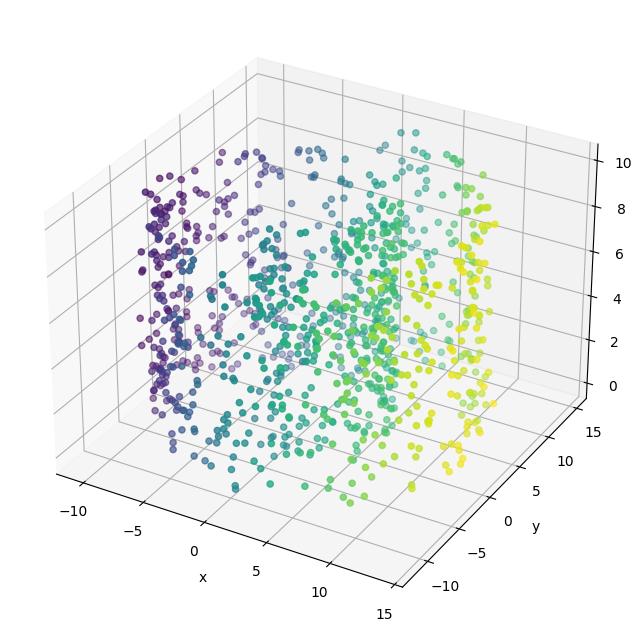

In [17]:
N = 1000
X = swiss_roll(N)

plt.figure(figsize=(10,8))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Isomap 2d projection of the swiss roll')

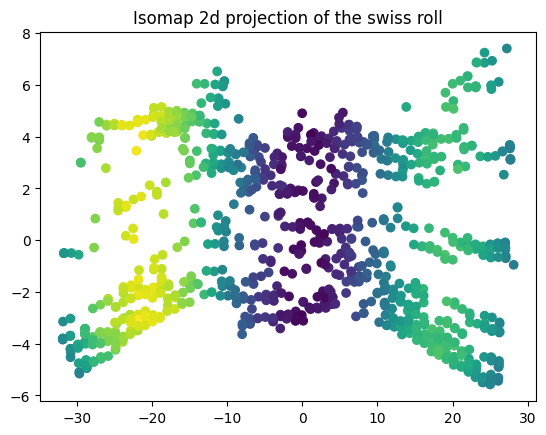

In [20]:
map = MyIsomap(n_components=2, n_neighbors=9)
Y = map.fit_transform(X)

plt.scatter(Y[:,0], Y[:,1], c = X[:,0])
plt.title('Isomap 2d projection of the swiss roll')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


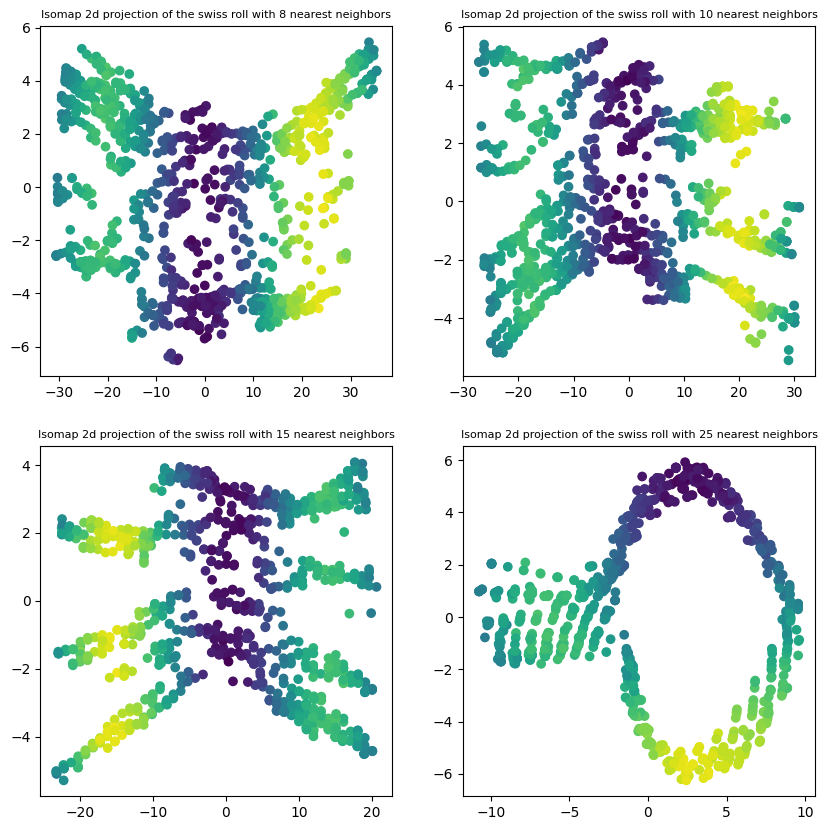

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))
axs = axs.flatten()

val = np.array([8,10,15,25])

for i in range(len(val)):
    map = MyIsomap(n_components=2, n_neighbors=val[i])
    Y = map.fit_transform(X)

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], c = X[:, 0])
    ax.set_title(f'Isomap 2d projection of the swiss roll with {val[i]} nearest neighbors', fontdict={'fontsize':8})

plt.show()

Nosiy version

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


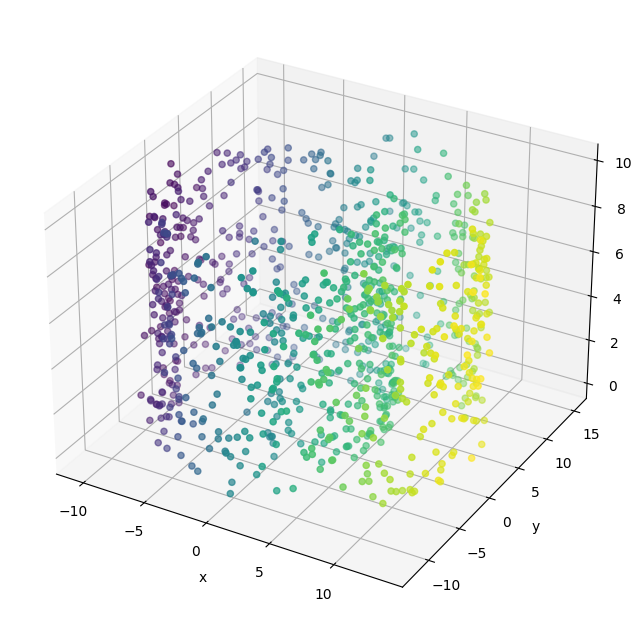

In [25]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate
    """
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) + np.random.normal(0, 0.5, n) #x coordinte
    data[:,1]=phi*np.sin(phi) + np.random.normal(0, 0.5, n) #y coordinate
    data[:,2]=psi #z coordinate
    return data

N = 1000
X = swiss_roll(N)

plt.figure(figsize=(10,8))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


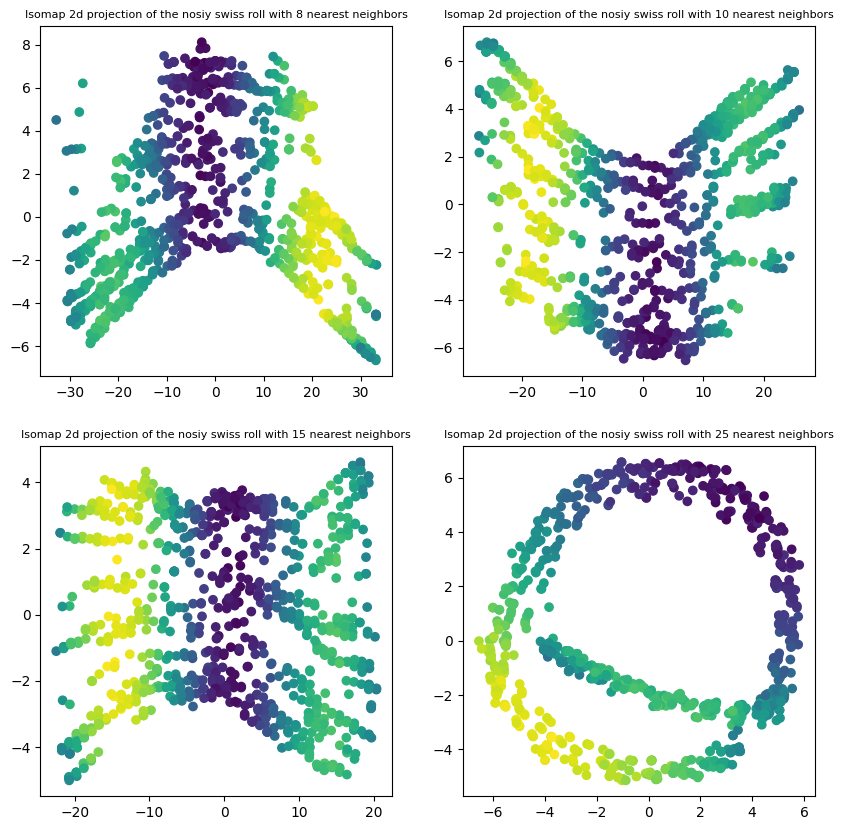

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))
axs = axs.flatten()

val = np.array([8,10,15,25])

for i in range(len(val)):
    map = Isomap(n_components=2, n_neighbors=val[i])
    Y = map.fit_transform(X)

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], c = X[:, 0])
    ax.set_title(f'Isomap 2d projection of the nosiy swiss roll with {val[i]} nearest neighbors', fontdict={'fontsize':8})

plt.show()

## Exercise 2

In [5]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [20]:
df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")
df = df.sample(n=1000)

y = df['Class']
X = df.drop('Class', axis=1)

encoder = OrdinalEncoder()
y=np.array(y)
encoder.fit(y.reshape(-1,1))
y = encoder.transform(y.reshape(-1, 1))

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)


In [21]:
Xtrain =  (Xtrain-Xtrain.mean() )/Xtrain.std()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


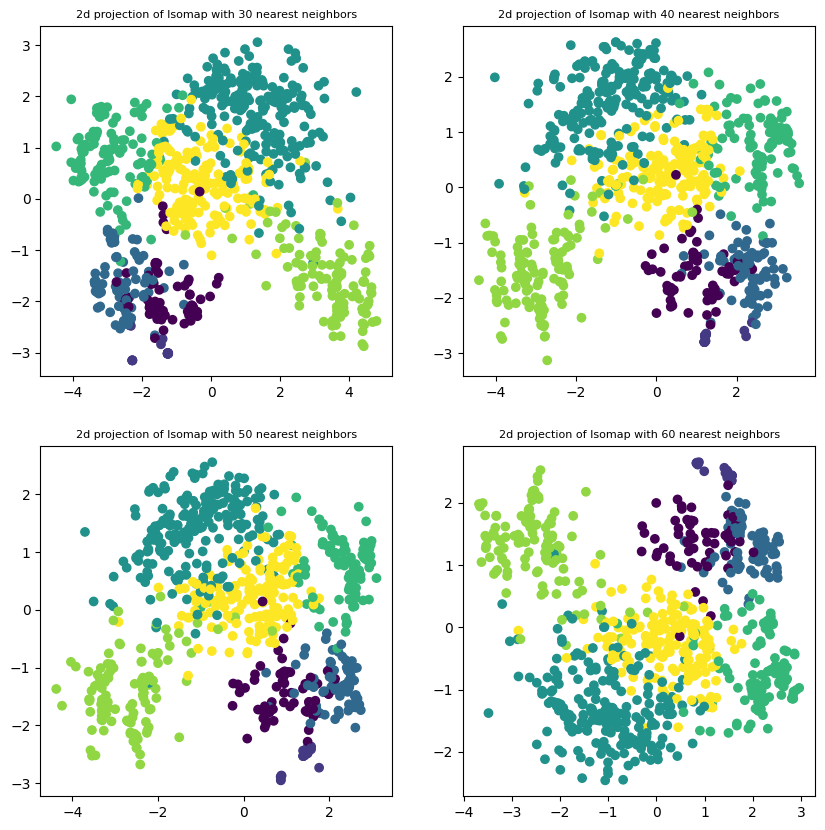

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))
axs = axs.flatten()

val = np.array([30,40,50,60])

for i in range(len(val)):
    map = MyIsomap(n_components=2, n_neighbors=val[i])
    Y = map.fit_transform(Xtrain)

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], c = ytrain)
    ax.set_title(f'2d projection of Isomap with {val[i]} nearest neighbors', fontdict={'fontsize':8})

plt.show()

sembra vadano tutti uguale... scegliamo 30

In [39]:
pca = MyIsomap(n_components=3, n_neighbors=30)
Y = pca.fit_transform(Xtrain)

<Figure size 1000x800 with 0 Axes>

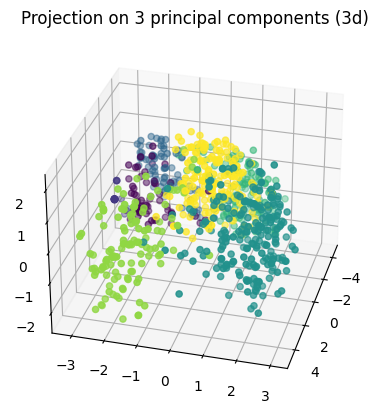

In [43]:
np.warnings.filterwarnings('ignore', category=np.ComplexWarning)
plt.figure(figsize=(10,8))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30,15)
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c = ytrain)
ax.set_title('Projection on 3 principal components (3d)')
plt.show()

In [ ]:
df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")
df = df.sample(n=1000)

y = df['Class']
X = df.drop('Class', axis=1)

encoder = OrdinalEncoder()
y=np.array(y)
encoder.fit(y.reshape(-1,1))
y = encoder.transform(y.reshape(-1, 1))

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)


- For an increasing number of principal components (1 to 16):
- - Apply a multinomial logistic regression to learn a model on the training set (use  ```sklearn.linear_model.LogisticRegression``` ).
- - Transform the test set with the matrix learned from the traning set. Make a prediction with the logistic model learned. 
- - Assess the quality of the predictions and comment on the results. 

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Xtest = (Xtest- Xtest.mean())/Xtest.std()
accuracy = np.zeros(16)
for k in range(1,17):
    # Y is the train standardized dataset projected to k PC
    map = MyIsomap(n_components= k, n_neighbors=30)
    Xtrain_proj = np.real(map.fit_transform(Xtrain))


    # fit a logistic regression using the dimension-reduced dataset Xtrain_proj (nxk instead of nxp, where p = 16)
    model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
    model.fit(Xtrain_proj, ytrain.ravel())

    
    map1 = MyIsomap(n_components= k, n_neighbors=30)
    Xtest_proj = np.real(map.fit_transform(Xtest))

    # Make a prediction with the logistic model learned.
    yhat = model.predict(Xtest_proj)

    # Assess the quality of the predictions
    acc = accuracy_score(ytest, yhat)
    accuracy[k-1] = acc
    print(f'Accuracy for {k} components: ', acc)
    

Accuracy for 1 components:  0.41
Accuracy for 2 components:  0.545
Accuracy for 3 components:  0.545
Accuracy for 4 components:  0.565
Accuracy for 5 components:  0.555
Accuracy for 6 components:  0.54
Accuracy for 7 components:  0.545
Accuracy for 8 components:  0.535
Accuracy for 9 components:  0.495
Accuracy for 10 components:  0.475
Accuracy for 11 components:  0.465
Accuracy for 12 components:  0.495
Accuracy for 13 components:  0.49
Accuracy for 14 components:  0.49
Accuracy for 15 components:  0.51
Accuracy for 16 components:  0.515


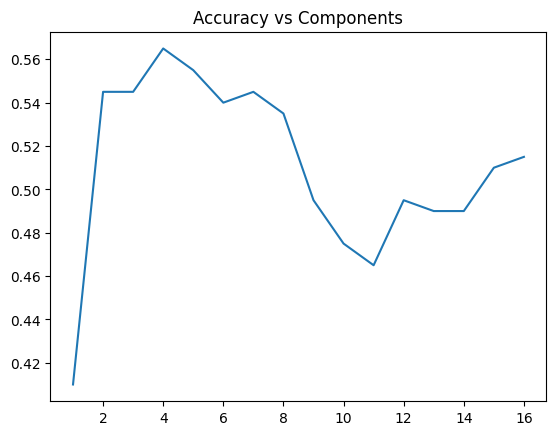

In [67]:
plt.plot(np.arange(1, 17), accuracy)
plt.title('Accuracy vs Components')
plt.show()